In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import resource
import pickle
import gc
import warnings
from tqdm.notebook import tqdm
import mlflow
from mlflow.models import infer_signature

%load_ext autoreload
%autoreload 2

In [ ]:
mlflow.set_tracking_uri(uri="https://mlflow.tsw24.cetic.be")

In [ ]:
from TRAIL24.TRAIL24.data.preprocess import *
from TRAIL24.TRAIL24.models.nn import *

In [ ]:
with open('../data/df_cluster_0.pkl', 'rb') as f:
        df = pickle.load(f)

num_rows = len(df)

# Calculate the halfway point
halfway_point = num_rows // 6

# Select the first half of the rows
df = df.iloc[:halfway_point]

# Preprocess the DataFrame
df_transformed = preprocess_dataframe(df, window_size=40, chunk_size=100)


# Define date ranges
train_start_date = '2009-07-14'
train_end_date = '2010-12-15'
test_start_date = '2010-12-15'
test_end_date = '2011-01-01'

# Finalize the DataFrame (split into train and test)
train, test = finalize_dataframe(df_transformed, train_start_date, train_end_date, test_start_date, test_end_date)

# Scale the first 40 columns
columns_to_scale = [f'lag_{i}' for i in range(1, 41)]
train, test = scale_features(train, test, columns_to_scale)

# Perform memory cleanup
del df_transformed, df
gc.collect()

print("Data preprocessing complete.")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx].astype("float32")
        features = torch.FloatTensor(row[:-5].values)  # All columns except the last 5
        year = torch.FloatTensor([row[-5]]).to(torch.int)
        month = torch.FloatTensor([row[-4]]).to(torch.int)  # Month is expected to be 0-11
        day = torch.FloatTensor([row[-3]]).to(torch.int)    # Day is expected to be 0-30
        hour = torch.FloatTensor([row[-2]]).to(torch.int)      # Hour is already 0-indexed (0-23)
        label = torch.FloatTensor([row[-1]])  # The last column
        return features, year, month, day, hour, label

    def __len__(self):
        return len(self.dataframe)

def create_data_loaders(data, chunk_size, batch_size):
    chunks = np.array_split(data, len(data) // chunk_size)
    data_loaders = []
    for chunk in chunks:
        dataset = CustomDataset(chunk)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        data_loaders.append(data_loader)
    return data_loaders

In [ ]:
def train_function(net, criterion, optimizer, data_loaders, n_epochs=5, device=torch.device("cuda")):
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True, threshold=0.1, patience=3, factor=0.5)
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        counter = 0
        for data_loader in data_loaders:
            for features, year, month, day, hour, labels in tqdm(data_loader):
                features = features.to(device)
                year = year.to(device)
                month = month.to(device)
                day = day.to(device)
                hour = hour.to(device)
                labels = labels.to(device)

                outputs = net(features, month, day, hour, year)
                loss = criterion(outputs, labels)
                epoch_loss += loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        print(f"epoch {epoch}")
        scheduler.step(epoch_loss / len(data_loaders))
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(data_loaders)}")
        with open(f'modelcheckpoint{epoch}.pickle', 'wb') as handle:
            pickle.dump([net, optimizer], handle, protocol=pickle.HIGHEST_PROTOCOL)
        collected = gc.collect()
    return net

def test_function(net, data_loaders, scaler, label_scaler, device=torch.device("cuda"), return_data=False):
    mse = MeanSquaredError().to(device)
    smape = SymmetricMeanAbsolutePercentageError().to(device)
    net.eval()
    list_outputs = []
    list_targets = []
    with torch.no_grad():  # to not reserve a memory space for gradients
        for data_loader in data_loaders:
            for features, year, month, day, hour, labels in tqdm(data_loader):
                features = features.to(device)
                year = year.to(device)
                month = month.to(device)
                day = day.to(device)
                hour = hour.to(device)
                labels = labels.to(device)

                outputs = net(features, month, day, hour, year)
                outputs = outputs.squeeze()
                labels = labels.squeeze()

                mse(outputs, labels)
                smape(outputs, labels)
                list_targets.append(labels.detach().unsqueeze(0))  # Ensure tensors are at least one-dimensional
                list_outputs.append(outputs.detach().unsqueeze(0))  # Ensure tensors are at least one-dimensional
    test_mse = mse.compute()
    test_smape = smape.compute()
    print(f"Test MSE: {test_mse} , SMAPE {test_smape}")
    if return_data:
        return torch.cat(list_outputs), torch.cat(list_targets), test_mse, test_smape

In [ ]:

input_size = 40  # Length of input time series
output_size = 1  # Length of output time series (forecast)
num_blocks = 12
num_hidden = 512
num_layers = 8
embedding_dim = 10
final_hidden = 512


nbeats_params = {
    'input_size': input_size,
    'output_size': output_size,
    'num_blocks': num_blocks,
    'num_hidden': num_hidden,
    'num_layers': num_layers
}

model_cfg = {
    'model_type': 'nbeats', 
    'model_params': nbeats_params, 
    'embedding_dim': 10, 
    'final_hidden': 256
}

net = create_model(**model_cfg)

device = "cuda"
net.to(device)

lr = 0.0005
n_epochs = 10
window_size = 40
chunk_size = 122880
batch_size = 1024*12*5

In [ ]:
# Assuming `train`, `test`, `sample` are pre-loaded DataFrames
train_loaders = create_data_loaders(train, chunk_size, batch_size)
test_loaders = create_data_loaders(test, chunk_size, batch_size)
#sample_loaders = create_data_loaders(sample, 100, 1)
print("data loaders are ready")

#del train, test, sample
del train, test
gc.collect()

/home/HubensN/miniconda3/envs/dev/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


NameError: name 'sample' is not defined

In [ ]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

net.to(device)

print("Model Started")

start_mem = get_memory_usage()
time1 = time.time()
net = train_function(net, criterion, optimizer, train_loaders, n_epochs=1, device=torch.device(device))
time2 = time.time()
print("training time is ", time2 - time1)
end_mem = get_memory_usage()
print(f"Memory used for model training: {end_mem - start_mem} MB")

net.to(device)
time3 = time.time()
*_, test_mse, test_smape = test_function(net, test_loaders, None, None, torch.device(device), return_data=True)
time4 = time.time()
print("inference time is ", time4 - time3)


sample_outputs, sample_targets, sample_mse = test_function(net, sample_loaders, None, None, torch.device(device), True)
plt.plot(sample_outputs.to("cpu"), "-o", color="blue", label="NBEATS Predictions", markersize=3)
plt.plot(sample_targets.to("cpu"), color="red", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for Electricity state 1st building")
plt.legend()
plt.show()

Model Started


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Quickstart")

# Start an MLflow run
with mlflow.start_run():

    mlflow.set_tag("Training Info", "TEST")

    
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    net.to(device)
    
    print("Model Started")
    
    start_mem = get_memory_usage()
    time1 = time.time()
    net = train_function(net, criterion, optimizer, train_loaders, n_epochs=1, device=torch.device(device))
    time2 = time.time()
    print("training time is ", time2 - time1)
    end_mem = get_memory_usage()
    print(f"Memory used for model training: {end_mem - start_mem} MB")
    
    net.to(device)
    time3 = time.time()
    *_, test_mse, test_smape = test_function(net, test_loaders, None, None, torch.device(device), return_data=True)
    time4 = time.time()
    print("inference time is ", time4 - time3)

    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_smape", test_smape)
    
    sample_outputs, sample_targets, sample_mse = test_function(net, sample_loaders, None, None, torch.device(device), True)
    plt.plot(sample_outputs.to("cpu"), "-o", color="blue", label="NBEATS Predictions", markersize=3)
    plt.plot(sample_targets.to("cpu"), color="red", label="Actual")
    plt.ylabel("Energy Consumption (MW)")
    plt.title(f"Energy Consumption for Electricity state 1st building")
    plt.legend()
    plt.show()

2024/09/04 19:44:02 INFO mlflow.tracking.fluent: Experiment with name 'MLflow Quickstart' does not exist. Creating a new experiment.


Model Started


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
net = create_model().to(device)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Test MSE: 5.135466575622559 , SMAPE 1.9296079874038696
inference time is  93.09827733039856


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Test MSE: 3.5050137042999268 , SMAPE 1.9443151950836182


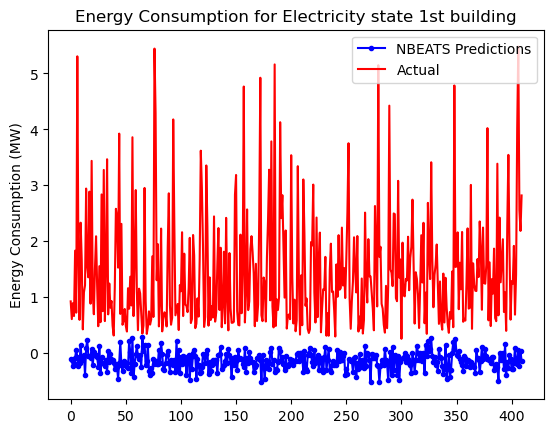

In [ ]:
time3 = time.time()
test_function(net, test_loaders, None, None, torch.device(device))
time4 = time.time()
print("inference time is ", time4 - time3)

sample_outputs, sample_targets, sample_mse = test_function(net, sample_loaders, None, None, torch.device(device), True)
plt.plot(sample_outputs.to("cpu"), "-o", color="blue", label="NBEATS Predictions", markersize=3)
plt.plot(sample_targets.to("cpu"), color="red", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for Electricity state 1st building")
plt.legend()
plt.show()

In [ ]:
torch.save(net, "saved_model_without_year.pth")

In [ ]:
nettt = torch.load("saved_model_without_year.pth")

In [ ]:
nettt

CombinedModel(
  (nbeats): NBEATS(
    (trend_blocks): ModuleList(
      (0-5): 6 x TrendBlock(
        (fc): ModuleList(
          (0): Linear(in_features=40, out_features=512, bias=True)
          (1-7): 7 x Linear(in_features=512, out_features=512, bias=True)
        )
        (backcast_fc): Linear(in_features=512, out_features=40, bias=True)
        (forecast_fc): Linear(in_features=512, out_features=1, bias=True)
      )
    )
    (seasonality_blocks): ModuleList(
      (0-5): 6 x SeasonalityBlock(
        (fc): ModuleList(
          (0): Linear(in_features=40, out_features=512, bias=True)
          (1-7): 7 x Linear(in_features=512, out_features=512, bias=True)
        )
        (backcast_fc): Linear(in_features=512, out_features=40, bias=True)
        (forecast_fc): Linear(in_features=512, out_features=1, bias=True)
      )
    )
  )
  (month_net): EmbeddingNetwork(
    (embedding): Embedding(12, 10)
  )
  (day_net): EmbeddingNetwork(
    (embedding): Embedding(31, 10)
  )
  (ho